# Tracé des RVI
Le RVI est un indicateur de végétation calculé à partir des données SAR. Le but de ce code est de montrer sa cohérence avec l'indicateur optique de couverture végétale FCOVER.

In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm

import sentry

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
%matplotlib inline

plt.rcParams["figure.figsize"] = (9,6)

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
target = "../data/Barro-Alto"
#target = "../data/Brunswick/"

Le répertoire source contient la zone d'intérêt, les fichiers SAFE .zip téléchargés et un fichier json : "geozone.json" qui décrit les éléments de décompression et la partie à extraire.

In [4]:
zone = sentry.getzone(target)
zone

{'name': 'Brunswick - Plomb, cuivre, zinc (Canada)',
 'bbox': [47.43925795795796,
  -65.93195605605604,
  47.52334204204204,
  -65.81984394394397],
 'step': 10,
 'GRD': '/Volumes/JLTD/Sentinel/GRD',
 'FCOVER': '/Volumes/JLTD/Sentinel/FCOVER',
 'NDVI': '/Volumes/JLTD/Sentinel/NDVI',
 'target': '../data/Brunswick/'}

La cellule suivante doit être décommentée si vous avez des données brutes et que vous souhaitez les recharger. Sinon, le code utilisera les données préchargées stockées dans les fichiers CSV.

In [5]:
#sentry.dataset.rvicompute(zone,renew=True)

In [6]:
R = sentry.dataset.rvi(zone)

In [7]:
R

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,DX,DY,ZIPFILE,RVIC
DATE,,,,,,,,,,,
2019-10-21,2.019591,0.011195,44.000092,38.728700,1,0.004300,1.243266,9089.0,-1583.0,S1A_IW_GRDH_1SDV_20191021T222002_20191021T2220...,2.023177
2019-10-26,2.023419,0.012876,41.443747,36.590827,-1,0.689922,-0.453819,4551.0,-6791.0,S1B_IW_GRDH_1SDH_20191026T103044_20191026T1031...,2.021625
2019-11-01,2.027644,0.015425,41.442749,36.590027,-1,0.690018,-0.453393,4546.5,-6791.0,S1A_IW_GRDH_1SDH_20191101T103126_20191101T1031...,2.022944
2019-11-02,2.019027,0.010777,44.001338,38.729638,1,0.004309,1.244064,9098.5,-1583.0,S1A_IW_GRDH_1SDV_20191102T222002_20191102T2220...,2.022826
2019-11-07,2.022608,0.011312,41.448008,36.594379,-1,0.689966,-0.454961,4561.0,-6786.0,S1B_IW_GRDH_1SDH_20191107T103044_20191107T1031...,2.021793
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-01,2.019640,0.011825,43.995191,38.724230,1,0.004568,1.244392,9094.5,-1573.0,S1A_IW_GRDH_1SDV_20210401T222005_20210401T2220...,2.021894
2021-04-06,2.024357,0.013588,41.454566,36.601529,-1,0.689580,-0.451993,4519.0,-6791.0,S1B_IW_GRDH_1SDH_20210406T103047_20210406T1031...,2.021752
2021-04-08,2.022757,0.013678,34.998373,31.101821,1,-0.012707,-0.795916,-6102.5,801.5,S1A_IW_GRDH_1SDV_20210408T221152_20210408T2212...,2.021812


DLAT et DLON correspondent aux coordonnées du vecteur topographique reliant le milieu de l'image de 250 km de large et 170 km de long acquise par le satellite et le centre de la zone d'intérêt.

<AxesSubplot:xlabel='DATE'>

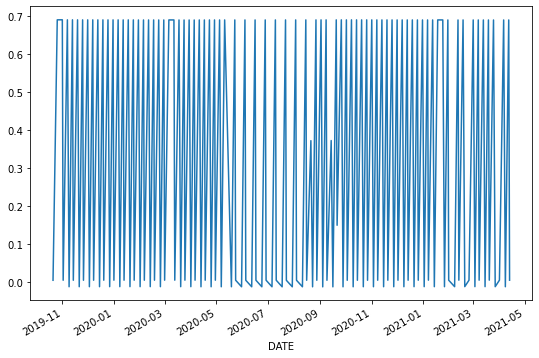

In [8]:
R['DLAT'].plot()

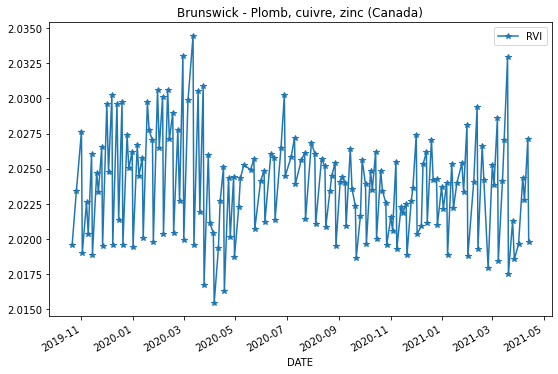

In [9]:
R['RVI'].plot(style='-*',legend=True)
plt.title(zone['name']);

In [10]:
rvi = R['RVI']

## Récupération de FCOVER

La ligne suivante est à décommenter si vous souhaitez recharger des données depuis une source nouvellement acquise.

In [11]:
# sentry.dataset.glscompute(zone,'FCOVER')

In [12]:
F = sentry.gls(zone,'FCOVER')

In [13]:
fcover = F['FCOVER']

In [14]:
rmse = F['RMSE']

## On fait un affichage superposé des deux indices.

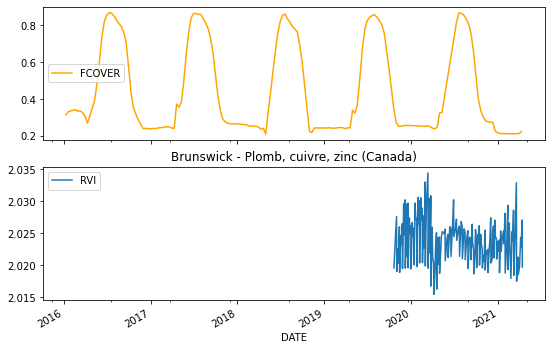

In [15]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
plt.title(zone['name'])
fcover.plot(ax=ax1,color='orange')
rvi.plot(ax=ax2)
ax1.legend(['FCOVER'])
ax2.legend(['RVI']);

## Apprentissage de la transformation du RVI
On cherche à recoller avec FCOVER.
Il faut prendre en compte l'angle de balayage.

In [16]:
from scipy.interpolate import interp1d

In [17]:
x = rvi.index
ry0 = rvi.values
ry = (ry0-min(ry0))/((max(ry0)-min(ry0)))

In [18]:
Fc = interp1d(pd.to_numeric(fcover.index),fcover.values,fill_value="extrapolate")

In [19]:
fy = Fc(pd.to_numeric(x))

In [20]:
Fe = interp1d(pd.to_numeric(rmse.index),rmse.values,fill_value="extrapolate")
fe = Fe(pd.to_numeric(x))

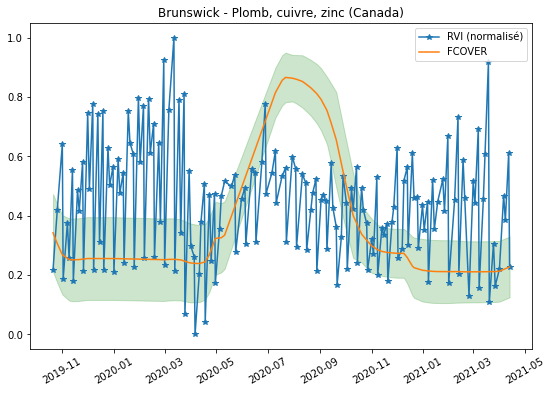

In [21]:
fig,ax = plt.subplots()
plt.plot(x,ry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.xticks(rotation=30)
ax.legend(['RVI (normalisé)','FCOVER'])
plt.title(zone['name']);

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [23]:
M = R[['RVI','INCIDENCE','ELEVATION','DLAT','DLON']].copy()
M['FCOVER'] = fy

J'ai testé si l'incidence et l'élévation avaient encore une importance, mais ce n'est pas le cas car des informations ont été prises en compte lors de la calibration du capteur.

In [24]:
res = smf.ols('FCOVER ~ RVI + DLAT + DLON', data=M).fit()

In [25]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 FCOVER   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.266
Date:                Wed, 30 Nov 2022   Prob (F-statistic):              0.288
Time:                        19:18:52   Log-Likelihood:                 27.971
No. Observations:                 166   AIC:                            -47.94
Df Residuals:                     162   BIC:                            -35.49
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.0824     13.039     -1.540      0.125     -45.831       5.666
RVI           10.1193      6.448      1.569      0.118      -2.613      22.852
DLAT          -0.0982      0.057     -1.708      0.089      -0.212       0.015
DLON           0.0180      0.025      0.710      0.479      -0.032       0.068
==============================================================================
Omnibus:                       36.680   Durbin-Watson:                   0.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.035
Skew:                           1.380   Prob(JB):                     1.85e-12
Kurtosis:                       3.444   Cond. No.                     2.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

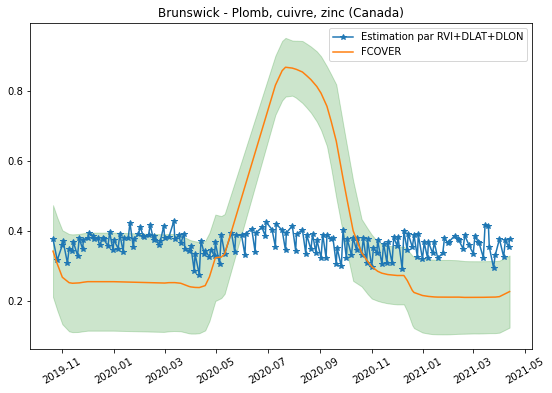

In [26]:
fig,ax = plt.subplots()
plt.plot(x,res.fittedvalues,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.xticks(rotation=30)
ax.legend(['Estimation par RVI+DLAT+DLON','FCOVER'])
plt.title(zone['name']);

##  Corrélations

In [27]:
from scipy.stats import kendalltau

In [28]:
tau0,pval0 = kendalltau(fy,ry0)
print("Corrélation entre FCOVER et RVI (tau,pValue):")
(tau0,pval0)

Corrélation entre FCOVER et RVI (tau,pValue):


(0.033078497270895735, 0.5278429771561746)

In [29]:
tau,pval = kendalltau(fy,res.fittedvalues) 
print("Corrélation entre FCOVER et l'estimation de FCOVER par RVI, DLAT et DLON:")
(tau,pval)

Corrélation entre FCOVER et l'estimation de FCOVER par RVI, DLAT et DLON:


(0.08650173401371407, 0.09876245282095482)

## Etude d'une correction de RVI par DLAT et DLON.
On cherche à éviter d'utiliser FCOVER pour avoir un calcul intrinsèque.

L'idée est de minimiser Delta_RVI par une correction du type RVI + alpha*DLAT + beta*DLON.

In [30]:
R['DRVI'] = rvi.diff()
R['DDLAT'] = R['DLAT'].diff()
R['DDLON'] = R['DLON'].diff()
resi = smf.ols('DRVI ~ DDLAT + DDLON -1',data=R).fit()
resi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   DRVI   R-squared (uncentered):                   0.723
Model:                            OLS   Adj. R-squared (uncentered):              0.719
Method:                 Least Squares   F-statistic:                              212.4
Date:                Wed, 30 Nov 2022   Prob (F-statistic):                    3.98e-46
Time:                        19:19:15   Log-Likelihood:                          726.62
No. Observations:                 165   AIC:                                     -1449.
Df Residuals:                     163   BIC:                                     -1443.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DDLAT          0.0042      0.000     10.455      0.000       0.003       0.005
DDLON         -0.0021      0.000    -10.299      0.000      -0.003      -0.002
==============================================================================
Omnibus:                        1.515   Durbin-Watson:                   3.143
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.111
Skew:                          -0.121   Prob(JB):                        0.574
Kurtosis:                       3.321   Cond. No.                         2.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

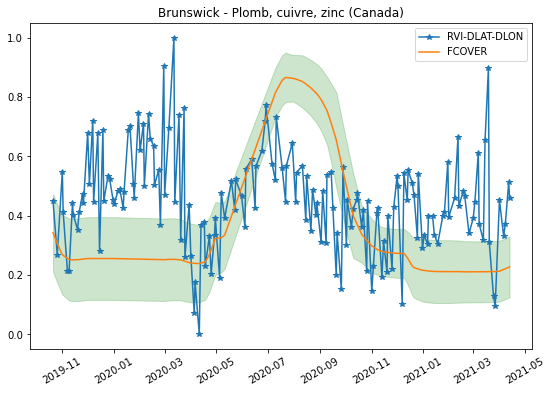

In [31]:
fig,ax = plt.subplots()
dry0 = rvi - R[['DLAT','DLON']].dot(resi.params.values)
dry = (dry0-dry0.min())/(dry0.max()-dry0.min())
plt.plot(x,dry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.xticks(rotation=30)
ax.legend(['RVI-DLAT-DLON','FCOVER'])
plt.title(zone['name']);

In [32]:
tau1,pval1 = kendalltau(fy,dry0)
print("Corrélation entre FCOVER et le RVI corrigé par DLAT et DLON :")
(tau1,pval1)

Corrélation entre FCOVER et le RVI corrigé par DLAT et DLON :


(0.07464616640777358, 0.15426710135196528)

## Lissage
Pour essayer de compenser l'effet de moyenne de FCOVER, on combine les mesures de RVI deux par deux.

(0.05526680216286106, 0.29606332572882377)

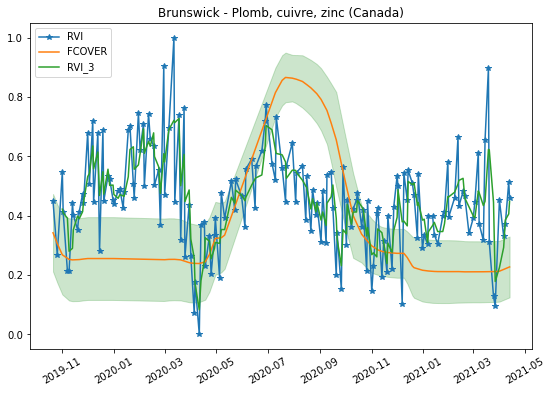

In [33]:
n=3
rdry = dry.rolling(window=n).mean()

fig,ax = plt.subplots()
plt.plot(x,dry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.plot(x,rdry)
plt.xticks(rotation=30)
ax.legend(['RVI','FCOVER','RVI_3'])
plt.title(zone['name']);

tau,pvalue = kendalltau(fy[n:],rdry[n:])
tau,pvalue

(0.05526680216286106, 0.29606332572882377)

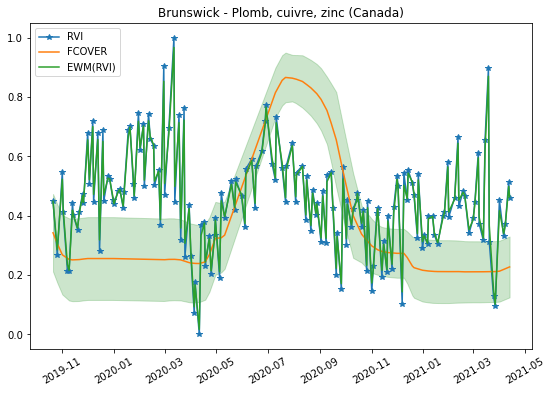

In [34]:
edry = dry.ewm(alpha=0.9).mean()

ig,ax = plt.subplots()
plt.plot(x,dry,'-*')
plt.plot(x,fy)
ax.fill_between(x,fy-fe,fy+fe,color='g',alpha=0.2)
plt.plot(x,edry)
plt.xticks(rotation=30)
ax.legend(['RVI','FCOVER','EWM(RVI)'])
plt.title(zone['name']);

tau,pvalue = kendalltau(fy[n:],rdry[n:])
tau,pvalue

_Jérôme Lacaille_